In [1]:
from IPython.display import Audio, display

import numpy as np

In [18]:
import matplotlib.pyplot as plt

In [2]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import glob
import torch
import matplotlib.pyplot as pltm
sys.path.append("../")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
mask_ind = _compute_mask_indices((200,512),0.75,10)

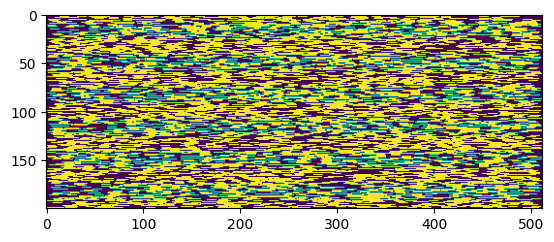

In [34]:
plt.imshow(mask_ind*255,)

In [4]:
def _compute_mask_indices(
    shape,
    mask_prob: float,
    mask_length: int,
    attention_mask= None,
    min_masks: int = 0,
):
    """
    Computes random mask spans for a given shape. Used to implement [SpecAugment: A Simple Data Augmentation Method for
    ASR](https://arxiv.org/abs/1904.08779). Note that this method is not optimized to run on TPU and should be run on
    CPU as part of the preprocessing during training.

    Args:
        shape: The shape for which to compute masks. This should be of a tuple of size 2 where
               the first element is the batch size and the second element is the length of the axis to span.
        mask_prob:  The percentage of the whole axis (between 0 and 1) which will be masked. The number of
                    independently generated mask spans of length `mask_length` is computed by
                    `mask_prob*shape[1]/mask_length`. Note that due to overlaps, `mask_prob` is an upper bound and the
                    actual percentage will be smaller.
        mask_length: size of the mask
        min_masks: minimum number of masked spans
        attention_mask: A (right-padded) attention mask which independently shortens the feature axis of
                        each batch dimension.
    """
    batch_size, sequence_length = shape

    if mask_length < 1:
        raise ValueError("`mask_length` has to be bigger than 0.")

    if mask_length > sequence_length:
        raise ValueError(
            f"`mask_length` has to be smaller than `sequence_length`, but got `mask_length`: {mask_length}"
            f" and `sequence_length`: {sequence_length}`"
        )

    # epsilon is used for probabilistic rounding
    epsilon = np.random.rand(1).item()

    def compute_num_masked_span(input_length):
        """Given input length, compute how many spans should be masked"""
        num_masked_span = int(mask_prob * input_length / mask_length + epsilon)
        num_masked_span = max(num_masked_span, min_masks)

        # make sure num masked span <= sequence_length
        if num_masked_span * mask_length > sequence_length:
            num_masked_span = sequence_length // mask_length

        # make sure num_masked span is also <= input_length - (mask_length - 1)
        if input_length - (mask_length - 1) < num_masked_span:
            num_masked_span = max(input_length - (mask_length - 1), 0)

        return num_masked_span

    # compute number of masked spans in batch
    input_lengths = (
        attention_mask.sum(-1).detach().tolist()
        if attention_mask is not None
        else [sequence_length for _ in range(batch_size)]
    )

    # SpecAugment mask to fill
    spec_aug_mask = np.zeros((batch_size, sequence_length), dtype=bool)
    spec_aug_mask_idxs = []

    max_num_masked_span = compute_num_masked_span(sequence_length)

    if max_num_masked_span == 0:
        return spec_aug_mask

    for input_length in input_lengths:
        # compute num of masked spans for this input
        num_masked_span = compute_num_masked_span(input_length)

        # get random indices to mask
        spec_aug_mask_idx = np.random.choice(
            np.arange(input_length - (mask_length - 1)), num_masked_span, replace=False
        )

        # pick first sampled index that will serve as a dummy index to pad vector
        # to ensure same dimension for all batches due to probabilistic rounding
        # Picking first sample just pads those vectors twice.
        if len(spec_aug_mask_idx) == 0:
            # this case can only happen if `input_length` is strictly smaller then
            # `sequence_length` in which case the last token has to be a padding
            # token which we can use as a dummy mask id
            dummy_mask_idx = sequence_length - 1
        else:
            dummy_mask_idx = spec_aug_mask_idx[0]

        spec_aug_mask_idx = np.concatenate(
            [spec_aug_mask_idx, np.ones(max_num_masked_span - num_masked_span, dtype=np.int32) * dummy_mask_idx]
        )
        spec_aug_mask_idxs.append(spec_aug_mask_idx)

    spec_aug_mask_idxs = np.array(spec_aug_mask_idxs)

    # expand masked indices to masked spans
    spec_aug_mask_idxs = np.broadcast_to(
        spec_aug_mask_idxs[:, :, None], (batch_size, max_num_masked_span, mask_length)
    )
    spec_aug_mask_idxs = spec_aug_mask_idxs.reshape(batch_size, max_num_masked_span * mask_length)

    # add offset to the starting indexes so that indexes now create a span
    offsets = np.arange(mask_length)[None, None, :]
    offsets = np.broadcast_to(offsets, (batch_size, max_num_masked_span, mask_length)).reshape(
        batch_size, max_num_masked_span * mask_length
    )
    spec_aug_mask_idxs = spec_aug_mask_idxs + offsets

    # ensure that we cannot have indices larger than sequence_length
    if spec_aug_mask_idxs.max() > sequence_length - 1:
        spec_aug_mask_idxs[spec_aug_mask_idxs > sequence_length - 1] = sequence_length - 1

    # scatter indices to mask
    np.put_along_axis(spec_aug_mask, spec_aug_mask_idxs, 1, -1)

    return spec_aug_mask

In [3]:
from configs.wav2vec2_characterwise_pretrained_ctc_newtokenizer_lm import Configs
CFG = Configs()

/usr/local/lib/python3.8/dist-packages/torch/storage.py:315: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.
  warnings.warn(message, UserWarning)


length of train: 862052, length of valid: 2369


In [5]:
from transformers.models.wav2vec2.modeling_wav2vec2 import _compute_mask_indices

In [ ]:
_compute_mask_indices

In [4]:
from trainer.wav2vec2_fintune_ctc_trainer import Trainer

In [5]:
CFG.DISTRIBUTED=False
train = Trainer(CFG)

freezing encoder layer....
Using collate function..
Autoregressive inference: False


In [6]:
loader = iter(train.train_loader)

In [18]:
z = next(loader)
[tt.shape for tt in z]
[tt.dtype for tt in z]

[torch.float32, torch.int64, torch.int64]

In [39]:
with torch.no_grad():
    pred = CFG.model(z[0].cuda().float(),z[1].cuda().long())